# CUDA C Best Practices Guide -- Shared Memory Optimisations

Change the following to run the same analysis on a different problem size:

In [52]:
%env OCLGRIND=/oclgrind
%env PROBLEM_SIZE=tiny
# %env PROBLEM_SIZE=small
# %env PROBLEM_SIZE=medium
# %env PROBLEM_SIZE=large

# set-up compulsory stuff
%load_ext rpy2.ipython

env: OCLGRIND=/oclgrind
env: PROBLEM_SIZE=tiny
The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


## Generate runtime data

In [53]:
! make clean
! make

rm sbd lsb.*.r0* aiwc_*.csv aiwc_*_itb.log Rplots.pdf
rm: cannot remove 'lsb.*.r0*': No such file or directory
Makefile:11: recipe for target 'clean' failed
make: *** [clean] Error 1
g++ synthetic-benchmark-driver.cpp -o sbd -lOpenCL -llsb -L/libscibench/lib -I/libscibench/include -std=c++11


Run the experiment and collect runtime data

In [54]:
! ./sbd ./gpu-strided-global-memory-access-unoptimised.cl $PROBLEM_SIZE 0 0 runtime

***** LSB_Init >gpu_memory_access< writing to >lsb.gpu_memory_access.r0< *****
Attempting kernel: ./gpu-strided-global-memory-access-unoptimised.cl with contents:
//shared memory in matrix multiplication ported from the [cuda c best practices guide](https://docs.nvidia.com/cuda/cuda-c-best-practices-guide/index.html#shared-memory-in-matrix-multiplication-c-aa)

__kernel void simpleMultiply(__global float *a,__global float *b,__global float *c, int N)
{
    int row = get_group_id(1) * get_local_size(1) + get_local_id(1);//blockIdx.y * blockDim.y + threadIdx.y;
    int col = get_group_id(0) * get_local_size(0) + get_local_id(0);//blockIdx.x * blockDim.x + threadIdx.x;
    float sum = 0.0f;
    for (int i = 0; i < TILE_DIM; i++) {
        sum += a[row*TILE_DIM+i] * b[i*N+col];
    }
    c[row*TILE_DIM+col] = sum;
}

__kernel void coalescedMultiply(__global float* a, __global float* b, __global float* c, int N)
{
    __local float aTile[TILE_DIM][TILE_DIM];
    __local float bTile[TILE_DIM

## Analyse runtimes data -- to ensure the OpenCL port of the cuda codes matches those shown in CUDA code-book

In [55]:
import pandas as pd
x = pd.read_csv('lsb.gpu_memory_access.r0', comment='#', sep="\s+")
#print(x)

y = x[(x.region == 'simpleMultiply_kernel') | (x.region == 'coalescedMultiply_kernel') | (x.region == 'transposedCoalescedMultiply_kernel')]



The distributions of 100 runtimes for each of the 3 kernels of memory striding for GPU optimisations are shown below.

/usr/local/lib/python3.5/dist-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


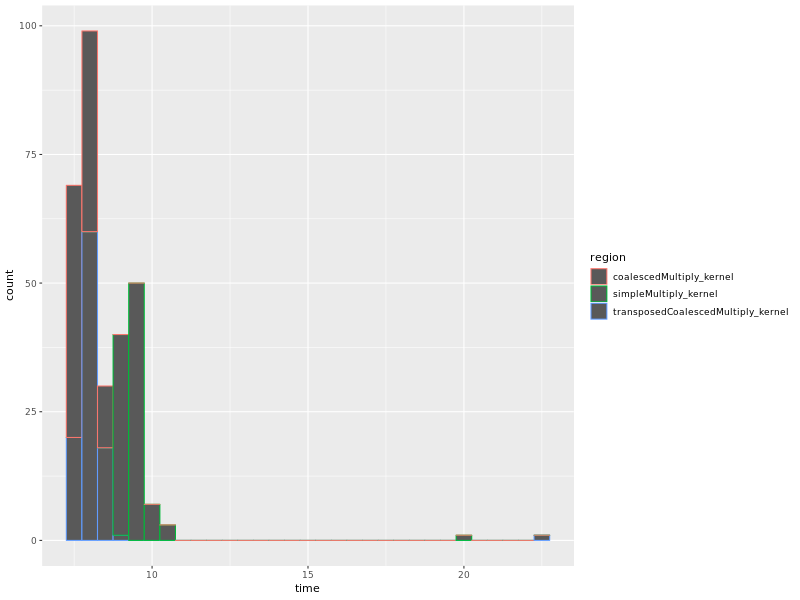

In [56]:
%%R -i y -w 800 -h 600 -u px

library(ggplot2)
pp = ggplot(y, aes_string(x='time', colour = 'region')) + geom_histogram(binwidth=.5)
print(pp)

**NOTE:** Do these distributions appear suspect? Perhaps move the timing regions to outside of the loop and divide by iterations -- in the C host source

In [57]:
z = y.drop(['id','overhead'],axis=1)
z = z.rename(columns={'time':'time (ms)'})
z.groupby(["region"]).mean()

## Generate AIWC feature-space per kernel

In [58]:
! make clean
! make
! $OCLGRIND/bin/oclgrind --workload-characterisation ./sbd ./gpu-strided-global-memory-access-unoptimised.cl $PROBLEM_SIZE 0 0 aiwc
! rm lsb.*.r0* #we aren't interested in runtime data anymore

rm sbd lsb.*.r0* aiwc_*.csv aiwc_*_itb.log Rplots.pdf
rm: cannot remove 'aiwc_*.csv': No such file or directory
rm: cannot remove 'aiwc_*_itb.log': No such file or directory
rm: cannot remove 'Rplots.pdf': No such file or directory
Makefile:11: recipe for target 'clean' failed
make: *** [clean] Error 1
g++ synthetic-benchmark-driver.cpp -o sbd -lOpenCL -llsb -L/libscibench/lib -I/libscibench/include -std=c++11
***** LSB_Init >gpu_memory_access< writing to >lsb.gpu_memory_access.r0< *****
Attempting kernel: ./gpu-strided-global-memory-access-unoptimised.cl with contents:
//shared memory in matrix multiplication ported from the [cuda c best practices guide](https://docs.nvidia.com/cuda/cuda-c-best-practices-guide/index.html#shared-memory-in-matrix-multiplication-c-aa)

__kernel void simpleMultiply(__global float *a,__global float *b,__global float *c, int N)
{
    int row = get_group_id(1) * get_local_size(1) + get_local_id(1);//blockIdx.y * blockDim.y + threadIdx.y;
    int col = get_gr

1024
+----------------------------------------------------------------------------------------------+
|90% Memory Footprint -- Number of unique memory addresses that cover 90% of memory accesses   |
+==============================================================================================+
total number of memory accesses = 35328
90% of memory accesses:31796
Number of unique memory addresses that cover 90% of memory accesses: 816
+----------------------------------------------------------------------------------------------+
|Global Memory Address Entropy -- Measure of the randomness of memory addresses                |
+==============================================================================================+
9.82473
+----------------------------------------------------------------------------------------------+
|Local Memory Address Entropy -- Measure of the spatial locality of memory addresses           |
+====================================================================

## Analyse AIWC data

First load in new data

In [59]:
import pandas as pd
simpleMultiply = pd.read_csv('aiwc_simpleMultiply_0.csv', sep=",")
coalescedMultiply = pd.read_csv('aiwc_coalescedMultiply_0.csv', sep=",")
transposedCoalescedMultiply = pd.read_csv('aiwc_transposedCoalescedMultiply_0.csv', sep=",")

Standardise according to existing data -- from the predictive modelling paper

In [60]:
simpleMultiply.head()

In [61]:
%%R -i simpleMultiply -i coalescedMultiply -i transposedCoalescedMultiply -o featdata.all -w 800 -h 600 -u px

load('/opencl-predictions-with-aiwc/data/intermediate/featdata.Rda')

simpleMultiply$application <- "matrix_multiplication"
simpleMultiply$kernel <- "simple_multiply"
simpleMultiply$invocation <- 0
simpleMultiply$size <- Sys.getenv('PROBLEM_SIZE')

coalescedMultiply$application <- "matrix_multiplication"
coalescedMultiply$kernel <- "coalesced_multiply"
coalescedMultiply$invocation <- 0
coalescedMultiply$size <- Sys.getenv('PROBLEM_SIZE')

transposedCoalescedMultiply$application <- "matrix_multiplication"
transposedCoalescedMultiply$kernel <- "transposed_coalesced_multiply"
transposedCoalescedMultiply$invocation <- 0
transposedCoalescedMultiply$size <- Sys.getenv('PROBLEM_SIZE')

featdata.all <- rbind(featdata.all,simpleMultiply)
featdata.all <- rbind(featdata.all,coalescedMultiply)
featdata.all <- rbind(featdata.all,transposedCoalescedMultiply)

/usr/local/lib/python3.5/dist-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


**TODO:** comparison plots between AIWC metrics

## Prediction Accuracy Of AIWC Metrics

Studentise the AIWC data

In [62]:
%%R -i featdata.all -o aiwc -w 800 -h 600 -u px

source('/opencl-predictions-with-aiwc/codes/restructure_aiwc_data.R')
pca_dat <- reorder_features(featdata.all)

pca_dat$opcode <- scale(pca_dat$opcode,scale=TRUE)[,1]
pca_dat$workitems <- scale(pca_dat$workitems,scale=TRUE)[,1]
pca_dat$total_barriers_hit <- scale(pca_dat$total_barriers_hit,scale=TRUE)[,1]
pca_dat$min_instructions_to_barrier <- scale(pca_dat$min_instructions_to_barrier,scale=TRUE)[,1]
pca_dat$max_instructions_to_barrier <- scale(pca_dat$max_instructions_to_barrier,scale=TRUE)[,1]
pca_dat$median_instructions_to_barrier <- scale(pca_dat$median_instructions_to_barrier,scale=TRUE)[,1]
pca_dat$max_simd_width <- scale(pca_dat$max_simd_width,scale=TRUE)[,1]
pca_dat$mean_simd_width <- scale(pca_dat$mean_simd_width,scale=TRUE)[,1]
pca_dat$stddev_simd_width <- scale(pca_dat$stddev_simd_width,scale=TRUE)[,1]
pca_dat$total_memory_footprint <- scale(pca_dat$total_memory_footprint,scale=TRUE)[,1]
pca_dat$ninety_percent_memory_footprint <- scale(pca_dat$ninety_percent_memory_footprint,scale=TRUE)[,1]
pca_dat$global_memory_address_entropy <- scale(pca_dat$global_memory_address_entropy,scale=TRUE)[,1]
pca_dat$local_memory_address_entropy_1 <- scale(pca_dat$local_memory_address_entropy_1,scale=TRUE)[,1]
pca_dat$local_memory_address_entropy_2 <- scale(pca_dat$local_memory_address_entropy_2,scale=TRUE)[,1]
pca_dat$local_memory_address_entropy_3 <- scale(pca_dat$local_memory_address_entropy_3,scale=TRUE)[,1]
pca_dat$local_memory_address_entropy_4 <- scale(pca_dat$local_memory_address_entropy_4,scale=TRUE)[,1]
pca_dat$local_memory_address_entropy_5 <- scale(pca_dat$local_memory_address_entropy_5,scale=TRUE)[,1]
pca_dat$local_memory_address_entropy_6 <- scale(pca_dat$local_memory_address_entropy_6,scale=TRUE)[,1]
pca_dat$local_memory_address_entropy_7 <- scale(pca_dat$local_memory_address_entropy_7,scale=TRUE)[,1]
pca_dat$local_memory_address_entropy_8 <- scale(pca_dat$local_memory_address_entropy_8,scale=TRUE)[,1]
pca_dat$local_memory_address_entropy_9 <- scale(pca_dat$local_memory_address_entropy_9,scale=TRUE)[,1]
pca_dat$local_memory_address_entropy_10 <- scale(pca_dat$local_memory_address_entropy_10,scale=TRUE)[,1]
pca_dat$total_unique_branch_instructions <- scale(pca_dat$total_unique_branch_instructions,scale=TRUE)[,1]
pca_dat$ninety_percent_branch_instructions <- scale(pca_dat$ninety_percent_branch_instructions,scale=TRUE)[,1]
pca_dat$branch_entropy_yokota <- scale(pca_dat$branch_entropy_yokota,scale=TRUE)[,1]
pca_dat$branch_entropy_average_linear <- scale(pca_dat$branch_entropy_average_linear,scale=TRUE)[,1]

aiwc <- pca_dat

Generate the predictive model

In [66]:
%%R -o model -w 800 -h 600 -u px

library(ranger)

load("/opencl-predictions-with-aiwc/data/intermediate/full_dat.Rda")

#manually typecast integer variables
int.inds <- c(2,6,7,8,9,10,11,12,13,16,17,29,30,34,37)

#standardise numeric variables
num.inds <- lapply(full_dat, is.numeric)
num.inds <- as.logical(num.inds)

for (i in seq(along = num.inds)){
            feature.name = names(full_dat[i])
            ifelse((any(i == int.inds) || num.inds[i] == 'FALSE' || feature.name == "kernel_time"), next, full_dat[i] <- scale(full_dat[i]))
                                } #end i loop

#use 20% of data for training
sampled_indices <- sample(seq_len(nrow(full_dat)), size = round(nrow(full_dat)*0.2))
train_dat <- full_dat[sampled_indices, ]
test_dat <- full_dat[-sampled_indices, ]

#remove certain variables unavailable during real-world training
train_dat = subset(train_dat, select = -size)
train_dat = subset(train_dat, select = -application)
train_dat = subset(train_dat, select = -kernel)
train_dat = subset(train_dat, select = -total_time)

#build the model
rgd.aiwc <- ranger(log(kernel_time)~.,
                   data = train_dat,
                   num.trees = 505,
                   mtry = 30,
                   min.node.size = 9,
                   importance = "impurity",
                   splitrule = 'variance',
                   respect.unordered.factors = 'order')

model <- rgd.aiwc

Make prediction with our AIWC metrics

In [107]:
%%R -i aiwc -i model  -w 800 -h 600 -u px

#manually typecast integer variables
#int.inds <- c(2,6,7,8,9,10,11,12,13,16,17,29,30,34,37)

#standardise numeric variables
#num.inds <- lapply(aiwc, is.numeric)
#num.inds <- as.logical(num.inds)

#for (i in seq(along = num.inds)){
#            feature.name = names(aiwc[i])
#            ifelse((any(i == int.inds) || num.inds[i] == 'FALSE' || feature.name == "kernel_time"), next, aiwc[i] <- scale(aiwc[i]))
#                                } #end i loop

x <- subset(aiwc, kernel=="simple_multiply")
x$device = 'gtx1080'
x$run = 0

prediction <- predict(model,type='response',data=x)
print(paste("simple multiply", round(prediction$pred**2,digits=2), "(ms)"))

x <- subset(aiwc, kernel=="coalesced_multiply")
x$device = 'gtx1080'
x$run = 0

prediction <- predict(model,type='response',data=x)
print(paste("coalesced multiply", round(prediction$pred**2,digits=2), "(ms)"))

x <- subset(aiwc, kernel=="transposed_coalesced_multiply")
x$device = 'gtx1080'
x$run = 0

prediction <- predict(model,type='response',data=x)
print(paste("transposed coalesced multiply", round(prediction$pred**2,digits=2), "(ms)"))


[1] "simple multiply 18.28 (ms)"
[1] "coalesced multiply 17.94 (ms)"
[1] "transposed coalesced multiply 17.94 (ms)"
